PROJECT CODE

TASKS:

1_Expansão com hidrolases - MEME and BLAST
2_Features - NS Machine learning - Clustering and Kmers
3_Functional Analysis - MOFA 
4_Estructural - Ensemble 

O que posso aplicar para a generalidade dos casos?


In [5]:
# Blast
import os
import pandas as pd
from Bio.Blast.Applications import NcbiblastpCommandline

# Arquivos de entrada
initial_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/initial_sequences.fasta"
new_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/blast_results.tsv"

# Remover o arquivo de saída, se existir
if os.path.exists(output_file):
    os.remove(output_file)

# Executar o BLAST usando o package do Anaconda e gravar os resultados no arquivo blast_results.tsv
blastp_cline = NcbiblastpCommandline(query=new_sequences_file, subject=initial_sequences_file, outfmt=6, out=output_file, evalue=0.45)
stdout, stderr = blastp_cline()

# Definir os cabeçalhos das colunas
column_headers = ['Query ID', 'Subject ID', 'Percent Identity', 'Alignment Length', 'Mismatches', 'Gap Openings',
                  'Query Start', 'Query End', 'Subject Start', 'Subject End', 'E-Value', 'Bit Score']

# Ler o arquivo de saída do BLAST
blast_results = pd.read_csv(output_file, sep='\t', header=None)

# Adicionar os cabeçalhos às colunas do DataFrame
blast_results.columns = column_headers

# Salvar o DataFrame com os cabeçalhos no arquivo de saída
blast_results.to_csv(output_file, sep='\t', index=False)


In [18]:
#MEME

# Arquivos de entrada
sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/merge.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/meme_output"

import subprocess

# Comando para executar o programa meme e redirecionar a saída para o arquivo
command = ["/opt/local/bin/meme",sequences_file, "-nmotifs", "3", "-oc", output_file]

# Executar o comando
subprocess.run(command)

print("Análise MEME concluída. Os resultados foram salvos no arquivo meme_results.txt.")



Análise MEME concluída. Os resultados foram salvos no arquivo meme_results.txt.


In [76]:
# EXPANSÃO DO DATASET
"""
import os
from Bio import SeqIO
import requests
# Expandir o dataset negativo com mais casos negativos

# Define os termos de busca e filtra por proteínas da classe hidrolase
search_term = 'hidrolase'
search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=protein&term={search_term}&retmax=100000'
search_result = requests.get(search_url).text
id_list = search_result.split('<Id>')[1:]
id_list = [id.split('</Id>')[0] for id in id_list]
print(id_list)

# Baixa as sequências das proteínas encontradas
fetch_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={id_list[0]}&rettype=fasta&retmode=text'
print(fetch_url)
print(requests.get(fetch_url).text)
output_file="/Users/Sergiomendes/Desktop/Project/data/testNotPET.fasta"

# Grava as sequências em um arquivo FASTA na pasta desejada
output_folder = '/Users/Sergiomendes/Desktop/Project/Code/data'
with open(output_file, 'w') as f:
    f.write(requests.get(fetch_url).text)
"""

'\nimport os\nfrom Bio import SeqIO\nimport requests\n# Expandir o dataset negativo com mais casos negativos\n\n# Define os termos de busca e filtra por proteínas da classe hidrolase\nsearch_term = \'hidrolase\'\nsearch_url = f\'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=protein&term={search_term}&retmax=100000\'\nsearch_result = requests.get(search_url).text\nid_list = search_result.split(\'<Id>\')[1:]\nid_list = [id.split(\'</Id>\')[0] for id in id_list]\nprint(id_list)\n\n# Baixa as sequências das proteínas encontradas\nfetch_url = f\'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={id_list[0]}&rettype=fasta&retmode=text\'\nprint(fetch_url)\nprint(requests.get(fetch_url).text)\noutput_file="/Users/Sergiomendes/Desktop/Project/data/testNotPET.fasta"\n\n# Grava as sequências em um arquivo FASTA na pasta desejada\noutput_folder = \'/Users/Sergiomendes/Desktop/Project/Code/data\'\nwith open(output_file, \'w\') as f:\n    f.write(requests.get(fe

Counter({1: 100, 0: 41})
Counter({0: 100, 1: 100})


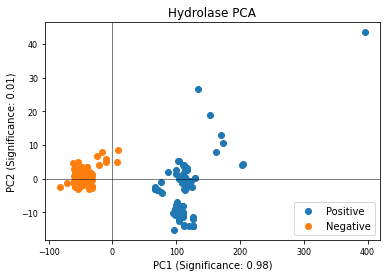

In [75]:
from Bio import SeqIO
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
from numpy import where

# Extrair os descriptores
def extract_descriptors(sequence):
    descriptor = [len(sequence), sequence.count('A'), sequence.count('C'),
                  sequence.count('D'), sequence.count('E'), sequence.count('F'),
                  sequence.count('G'), sequence.count('H'), sequence.count('I'),
                  sequence.count('K'), sequence.count('L'), sequence.count('M'),
                  sequence.count('N'), sequence.count('P'), sequence.count('Q'),
                  sequence.count('R'), sequence.count('S'), sequence.count('T'),
                  sequence.count('V'), sequence.count('W'), sequence.count('Y')]
    return descriptor

# Construir o dataframe
def create_dataframe(positive_file, negative_file):
    positive_sequences = list(SeqIO.parse(positive_file, 'fasta'))
    negative_sequences = list(SeqIO.parse(negative_file, 'fasta'))

    sequences = positive_sequences + negative_sequences
    labels = [0] * len(positive_sequences) + [1] * len(negative_sequences)
    descriptors = [extract_descriptors(str(seq.seq)) for seq in sequences]

    df = pd.DataFrame({'Label': labels, 'Descriptor': descriptors})
    return df


positive_file = '/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta'
negative_file = '/Users/Sergiomendes/Desktop/Project/data/notPET.fasta'

df = create_dataframe(positive_file, negative_file)

# Executar PCA
pca = PCA(n_components=2)  # Set n_components to 2
descriptors = df['Descriptor'].values.tolist()
pca_result = pca.fit_transform(descriptors)

# Adicionar os resultados ao dataframe
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

# Extrair os valores de significância
explained_variance_ratio = pca.explained_variance_ratio_

# Extrair features e labels
X = df[['PC1', 'PC2']].values
y = df['Label'].values

# Sumarizar a distribuição de classes
counter = Counter(y)
print(counter)

# Aplicar SMOTE de modo a gerar amostras sintéticas para os casos negativos
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Sumarizar a nova distribuição de classes
counter = Counter(y_resampled)
print(counter)

# Mapeamento das labels para as legendas desejadas
label_legend_mapping = {0: 'Positive', 1: 'Negative'}

# Visualizar o gráfico de dispersão 
for label, _ in counter.items():
    row_ix = where(y_resampled == label)[0]
    plt.scatter(X_resampled[row_ix, 0], X_resampled[row_ix, 1], label=label_legend_mapping[label])

#Título
plt.title('Hydrolase PCA')

# Legenda do eixo X
plt.xlabel('PC1')
plt.xticks(fontsize=8)

# Legenda do eixo Y
plt.ylabel('PC2')
plt.yticks(fontsize=8)

# Eixos X e Y
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Adicionar os valores de significância nos eixos
plt.xlabel(f'PC1 (Significance: {explained_variance_ratio[0]:.2f})')
plt.xticks(fontsize=8)
plt.ylabel(f'PC2 (Significance: {explained_variance_ratio[1]:.2f})')
plt.yticks(fontsize=8)
plt.legend()

# Salvar o gráfico
save_path = '/Users/Sergiomendes/Desktop/Project/data/clustering_result.png'
plt.savefig(save_path)

plt.show()


In [ ]:
# FUNCTIONAL ANALYSIS - MOFA

import numpy as np
from mofapy2.mofapy2 import MOFA
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from Bio.SeqUtils.ProtParam import ProteinAnalysis

merge_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/merge.fasta"

# Carregar as sequências de proteínas do arquivo merge.fasta
merge_sequences = []
with open(merge_sequences_file, "r") as merge_seq_file:
    for record in SeqIO.parse(merge_seq_file, "fasta"):
        merge_sequences.append(str(record.seq))

# Codificar as sequências de proteínas usando One-Hot Encoding
encoder = OneHotEncoder(dtype=np.int8)
encoded_sequences = encoder.fit_transform(merge_sequences).toarray()

# Extrair descritores funcionais das sequências de proteínas
def extract_functional_descriptors(sequences):
    descriptors = []
    for sequence in sequences:
        protein = ProteinAnalysis(str(sequence))
        hydrophobicity = protein.protein_scale(window=9, param_dict=ProteinAnalysisData.kd, remove_zero=False)
        thermal_stability = protein.temperature_stability()
        enzymatic_activity = calculate_enzymatic_activity(sequence)
        secondary_structure_fraction = protein.secondary_structure_fraction()
        charge_properties = calculate_charge_properties(sequence)
        
        descriptor = [hydrophobicity, thermal_stability, enzymatic_activity]
        descriptor.extend(secondary_structure_fraction)
        descriptor.extend(charge_properties)
    
        descriptors.append(descriptor)
    
    return descriptors

# Função para calcular a atividade enzimática específica para degradação de PET ????

def calculate_enzymatic_activity(sequence):
# Implemente sua lógica de cálculo da atividade enzimática aqui
# Retorne o valor da atividade enzimática específica para a sequência de proteína fornecida
pass

#Função para calcular as propriedades de carga da sequência de proteína ????

def calculate_charge_properties(sequence):
# Implemente sua lógica de cálculo das propriedades de carga aqui
# Retorne os valores das propriedades de carga relevantes para a sequência de proteína fornecida
pass

# Extrair descritores funcionais das sequências de proteínas
functional_descriptors = extract_functional_descriptors(encoded_sequences)

# Combinar descritores funcionais com as sequências codificadas
X = np.hstack((encoded_sequences, np.array(functional_descriptors)))

# Configurar e executar o MOFA
model = MOFA()
model.set_data_matrix(X)
model.fit(n_factors=3)  # Definir o número de fatores latentes desejado

# Analisar os resultados do MOFA
factors = model.get_factors()
loadings = model.get_loadings()

# Exemplo de impressão dos resultados
for factor_idx, factor in enumerate(factors):
    print(f"Factor {factor_idx + 1}:")
    print(factor)
    print("")

for loading_idx, loading in enumerate(loadings):
    print(f"Loading {loading_idx + 1}:")
    print(loading)
    print("")




In [ ]:
# ESTRUCTURAL ANALYSIS - ENSEMBLE

import pyconfold
from Bio import SeqIO

# Caminho para o arquivo FASTA contendo a sequência da proteína alvo
sequence_file = "/Users/Sergiomendes/Desktop/Project/data/merge.fasta"

# Ler a sequência da proteína alvo do arquivo FASTA
sequence = ""
with open(sequence_file, "r") as seq_file:
    for record in SeqIO.parse(seq_file, "fasta"):
        sequence = str(record.seq)
        break

# Configurar os parâmetros para a execução do CONFOLD
confold_params = pyconfold.ConfoldParams()

# Definir outros parâmetros conforme necessário, por exemplo:
# confold_params.num_models = 5  # Número de modelos a serem gerados

# Executar o CONFOLD para gerar os modelos de proteínas
models = pyconfold.run_confold(sequence, confold_params)

# Os modelos gerados estão armazenados na variável "models"
# Cada modelo é um objeto da classe "pyconfold.ConfoldModel"
# Você pode acessar informações e propriedades dos modelos, como a pontuação (score) e a estrutura 3D

# Exemplo de impressão dos modelos e suas pontuações
for i, model in enumerate(models):
    print(f"Model {i+1}:")
    print(f"Score: {model.score}")
    print(f"3D Structure:\n{model.structure}\n")
